Shape optimization
==================

## Setup

As always, let's import `drjit` and `mitsuba` and set a differentiation-aware variant.

In [1]:
import matplotlib.pyplot as plt 
import os
import drjit as dr
import mitsuba as mi
import torch

mi.set_variant('cuda_ad_rgb', 'llvm_ad_rgb')
torch.cuda.set_device(0)
mi.util.dr.set_device(0)

## Batched rendering

In [2]:
sensor_count = 8
sensor = {
    'type': 'batch',
    'film': {
        'type': 'hdrfilm',
        'width': 256 * sensor_count, 'height': 256,
        'filter': {'type': 'gaussian'},
        'sample_border': True
    }
}
# The batch sensor expects a list of nested sensors. Here we will generate 8 viewpoints evenly distributed on the sphere, using the [Fibonacci lattice][1].

# [1]: http://extremelearning.com.au/evenly-distributing-points-on-a-sphere/

from mitsuba import ScalarTransform4f as T

golden_ratio = (1 + 5**0.5)/2
for i in range(sensor_count):
    theta = 2 * dr.pi * i / golden_ratio
    phi = dr.acos(1 - 2*(i+0.5)/sensor_count)
    
    d = 5
    origin = [
        d * dr.cos(theta) * dr.sin(phi),
        d * dr.sin(theta) * dr.sin(phi),
        d * dr.cos(phi)
    ]
    
    sensor[f"sensor_{i}"] = {
        'type': 'perspective',
        'fov': 45,
        'to_world': T.look_at(target=[0, 0, 0], origin=origin, up=[0, 1, 0])
    }
    scene_dict = {
    'type': 'scene',
    'integrator': {
        'type': 'direct_reparam',
    },
    'sensor': sensor,
    'emitter': {
        'type': 'envmap',
        'filename': "../scenes/textures/envmap2.exr",
    },
    'shape': {
        'type': 'ply',
        'filename': "../scenes/meshes/suzanne.ply",
        'bsdf': {'type': 'diffuse'}
    }
}

scene_target = mi.load_dict(scene_dict)
# generate pictures from all view points
def plot_batch_output(out: mi.TensorXf):
    fig, ax = plt.subplots(figsize=(5*sensor_count, 5))
    ax.imshow(mi.util.convert_to_bitmap(out))
    ax.axis('off');

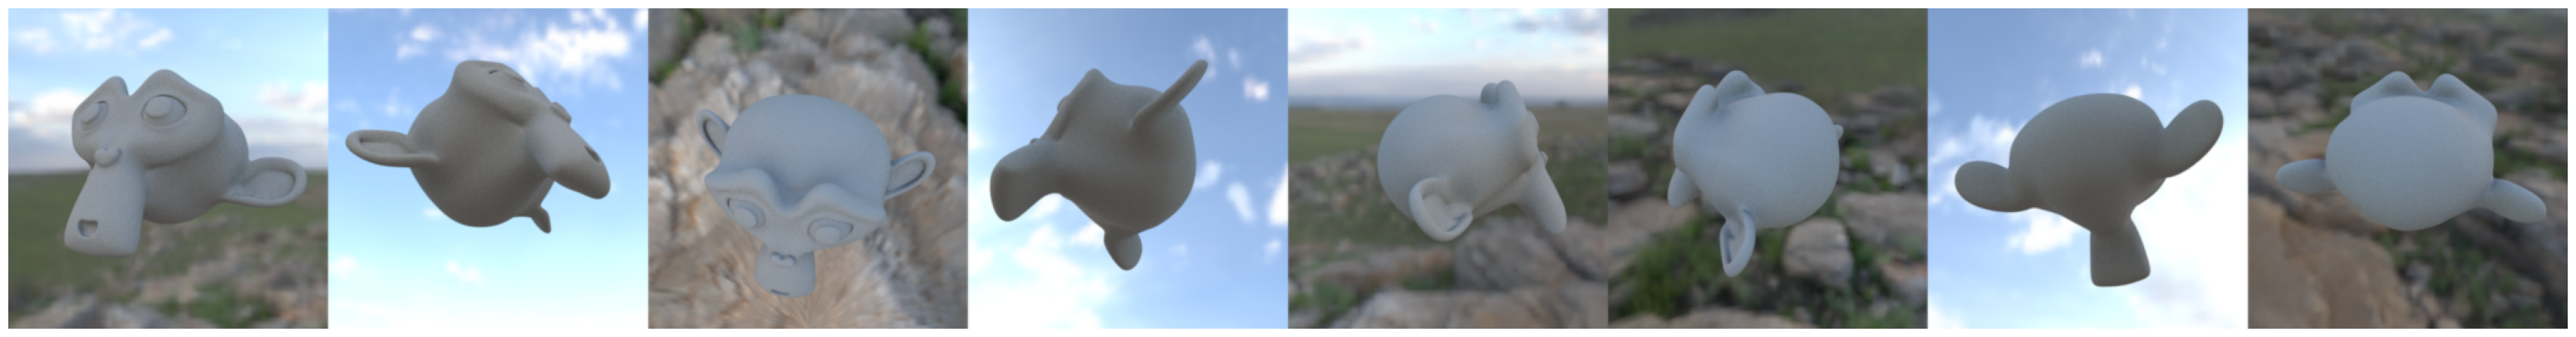

In [3]:
ref_img = mi.render(scene_target, spp=256)
plot_batch_output(ref_img)

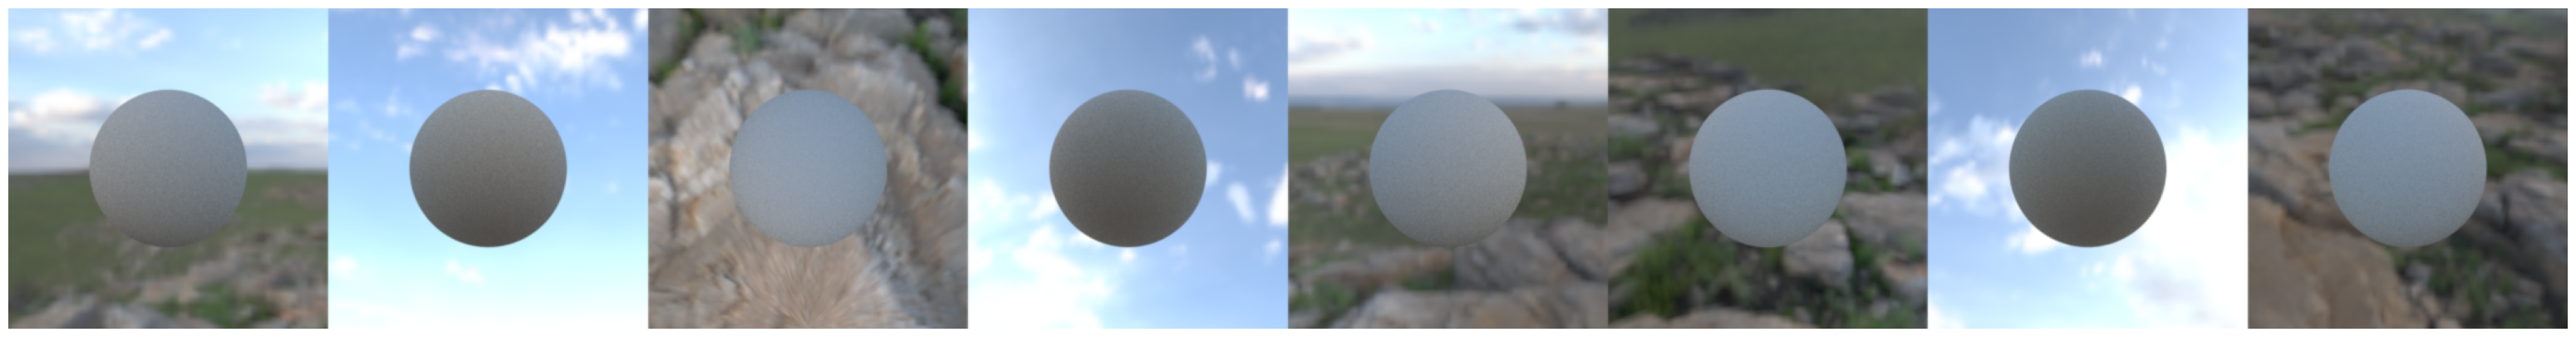

In [4]:
# spawn default shape that we want to optimise
scene_dict['shape']['filename'] = 'C:/Users/AQ14980/Desktop/repos/NextFace/scenes/meshes/ico_10k.ply'
scene_source = mi.load_dict(scene_dict)

init_img = mi.render(scene_source, spp=128)
plot_batch_output(init_img)

## Large Steps Optimization

In [5]:
# !pip install cholespy
lambda_ = 25
params = mi.traverse(scene_source)

ls = mi.ad.LargeSteps(params['shape.vertex_positions'], params['shape.faces'], lambda_)
# We also use a slighlty modified version of the adam optimizer, that uses a uniform second moment for all parameters. This can be done by setting `uniform=True` when instantiating the optimizer.
opt = mi.ad.Adam(lr=1e-1, uniform=True)
# convert back and forth cartesian -> diff representation vertex coords.
# init latent variable
opt['u'] = ls.to_differential(params['shape.vertex_positions'])

#otpimisation 
iterations = 200 if 'PYTEST_CURRENT_TEST' not in os.environ else 5
for it in range(iterations):
    loss = mi.Float(0.0)

    # Retrieve the vertex positions from the latent variable
    params['shape.vertex_positions'] = ls.from_differential(opt['u'])
    params.update()

    img = mi.render(scene_source, params, seed=it, spp=16)

    # L1 Loss
    loss = dr.mean(dr.abs(img - ref_img))
    dr.backward(loss)
    opt.step()

    print(f"Iteration {1+it:03d}: Loss = {loss[0]:6f}", end='\r')

Iteration 001: Loss = 0.037885/rIteration 002: Loss = 0.033866/rIteration 003: Loss = 0.030678/rIteration 004: Loss = 0.028240/rIteration 005: Loss = 0.027163/rIteration 006: Loss = 0.026601/rIteration 007: Loss = 0.026476/rIteration 008: Loss = 0.026306/rIteration 009: Loss = 0.025782/rIteration 010: Loss = 0.025038/rIteration 011: Loss = 0.024127/rIteration 012: Loss = 0.023176/rIteration 013: Loss = 0.022317/rIteration 014: Loss = 0.021655/rIteration 015: Loss = 0.021026/rIteration 016: Loss = 0.020277/rIteration 017: Loss = 0.019427/rIteration 018: Loss = 0.018430/rIteration 019: Loss = 0.017336/rIteration 020: Loss = 0.016565/rIteration 021: Loss = 0.016258/rIteration 022: Loss = 0.016042/rIteration 023: Loss = 0.015731/rIteration 024: Loss = 0.015316/rIteration 025: Loss = 0.014994/rIteration 026: Loss = 0.014620/rIteration 027: Loss = 0.014251/rIteration 028: Loss = 0.013855/rIteration 029: Loss = 0.013446/rIteration 030: Loss = 0.013084/rIteration 031: Loss = 0.012627/rIteratio

KeyboardInterrupt: 

## Intermediate result

In [ ]:
# Update the mesh after the last iteration's gradient step
params['shape.vertex_positions'] = ls.from_differential(opt['u'])
params.update();

final_img = mi.render(scene_source, spp=128)
plot_batch_output(final_img)

## Remeshing

The result above can be further improved with the help of remeshing. By increasing the tesselation of the mesh, we will be able to recover more details of the target shape. Intuitively, the intent of this step is similar to other "coarse-to-fine" optimization strategies. For example, in the [caustics][1] or the [volume optimization][2] tutorial we increase the resolution of texture that is being optimized over time.

We will use the Botsch-Kobbelt remeshing algorithm provided by the `gpytoolbox` package:

[1]: https://mitsuba.readthedocs.io/en/stable/src/inverse_rendering/caustics_optimization.html
[2]: https://mitsuba.readthedocs.io/en/stable/src/inverse_rendering/volume_optimization.html

In [ ]:
# !pip install gpytoolbox
import numpy as np
import torch 

torch.cuda.empty_cache()

v_np = params['shape.vertex_positions'].numpy().reshape((-1,3)).astype(np.float64)
f_np = params['shape.faces'].numpy().reshape((-1,3))
# The Botsch-Kobbelt remeshing algorithm takes a "target edge length" as input argument. This controls the desired tesselation of the mesh. Since we want to increase resolution, we will set this as half of the mean edge length of the current mesh.
# Compute average edge length
l0 = np.linalg.norm(v_np[f_np[:,0]] - v_np[f_np[:,1]], axis=1)
l1 = np.linalg.norm(v_np[f_np[:,1]] - v_np[f_np[:,2]], axis=1)
l2 = np.linalg.norm(v_np[f_np[:,2]] - v_np[f_np[:,0]], axis=1)

target_l = np.mean([l0, l1, l2]) / 2

#We can now run the Botsch-Kobbelt remeshing algorithm. It runs for a user-specified number of iterations, which we set to 5 here. Further details on about this algorithm, can be found it the package's [documentation][1].
from gpytoolbox import remesh_botsch
v_new, f_new = remesh_botsch(v_np, f_np, i=5, h=target_l, project=True)
# put v_new and f_new on gpu again
# Create torch tensors from the numpy arrays
v_new_t = torch.from_numpy(v_new)
f_new_t = torch.from_numpy(f_new)

# # Move tensors to the GPU
v_new_t = v_new_t.to('cuda')
f_new_t = f_new_t.to('cuda')

# The new vertices and faces must now be passed to our Mitsuba `Mesh`. If the mesh has other attributes (e.g. UV coordinates), they also need to be updated. By default, Mitsuba will reset these to 0 if the vertex or face count is altered.
params = mi.traverse(scene_source)
# params['shape.vertex_positions'] = mi.Float(v_new.flatten().astype(np.float32))
# params['shape.faces'] = mi.Int(f_new.flatten())
params['shape.vertex_positions'] = dr.ravel(mi.TensorXf(v_new_t.to(torch.float32)))
params['shape.faces'] = dr.ravel(mi.TensorXf(f_new_t.to(torch.float32)))
params.update();

# mesh topology is different, we need new latent variable
ls = mi.ad.LargeSteps(params['shape.vertex_positions'], params['shape.faces'], lambda_)
opt = mi.ad.Adam(lr=1e-1, uniform=True)
opt['u'] = ls.to_differential(params['shape.vertex_positions'])

torch.cuda.empty_cache()

# optimisation
iterations = 150 if 'PYTEST_CURRENT_TEST' not in os.environ else 5
for it in range(iterations):
    loss = mi.Float(0.0)

    # Retrieve the vertex positions from the latent variable
    params['shape.vertex_positions'] = ls.from_differential(opt['u'])
    params.update()

    img = mi.render(scene_source, params, seed=it, spp=16)

    # L1 Loss
    loss = dr.mean(dr.abs(img - ref_img))
    dr.backward(loss)
    opt.step()

    print(f"Iteration {1+it:03d}: Loss = {loss[0]:6f}", end='/r')
    
params['shape.vertex_positions'] = ls.from_differential(opt['u'])
params.update();

## Final result

Finally, let's compare our end result (bottom) to our reference views (top).

In [ ]:
final_img = mi.render(scene_source, spp=128)

fig, ax = plt.subplots(nrows=2, figsize=(5*sensor_count, 10))
ax[0].set_title("Reference", y=0.3, x=-0.005, rotation=90, fontsize=20)
ax[1].set_title("Optimized shape", y=0.2, x=-0.005, rotation=90, fontsize=20)
for i, img in enumerate((ref_img, final_img)):
    ax[i].imshow(mi.util.convert_to_bitmap(img))
    ax[i].axis('off')

Note that the results could be further improved by e.g. using more input views, or using a less agressive step size and more iterations.

## See also

- [<code>mitsuba.ad.LargeSteps</code>][1]
- [<code>direct_reparam</code> plugin][2]
- [<code>batch</code> plugin][3]

[1]: https://mitsuba.readthedocs.io/en/latest/src/api_reference.html#mitsuba.ad.LargeSteps
[2]: https://mitsuba.readthedocs.io/en/latest/src/generated/plugins_integrators.html#reparameterized-direct-integrator-direct-reparam
[3]: https://mitsuba.readthedocs.io/en/latest/src/generated/plugins_sensors.html#batch-sensor-batch